共通部<br>
ライブラリインポート
関数宣言

In [84]:
#tmm
from __future__ import division, print_function, absolute_import

from tmm import (coh_tmm, unpolarized_RT, ellips,
                       position_resolved, find_in_structure_with_inf)

from numpy import pi, linspace, inf, array
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
#%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
from scipy import interpolate
from matplotlib.pyplot import plot,show,xlabel,ylabel,title,legend,grid,axis
import csv
#結果保存用
import pickle
#ディレクトリ作成およびファイル存在確認用
import os
#時間計測用
import time
#日付取得用
import datetime

#tmmの使用に必要？
try:
    import colorpy.illuminants
    import colorpy.colormodels
    from tmm import color
    colors_were_imported = True
except ImportError:
    # without colorpy, you can't run sample5(), but everything else is fine.
    colors_were_imported = False

# "5 * degree" is 5 degrees expressed in radians
# "1.2 / degree" is 1.2 radians expressed in degrees
degree = pi/180

#GPyOpt
import GPy
import GPyOpt

In [102]:
#波長とそれぞれの屈折率の辞書から構造の配列を作成する関数
def dict_to_list(n_dict,STR):
    n_list=np.zeros((len(n_dict["Wavelength"]),len(STR)+1),dtype=complex)
    n_list[:,0]=n_dict["Wavelength"]
    layer=0
    for i in STR:
        for l in range(len(n_dict["Wavelength"])):
            n_list[l][layer+1]=n_dict[i][l]
        layer=layer+1
    return n_list

#Rs,Ts,As,Rp,Tp,Apすべてを計算する関数(波長依存用)
def coh_tmm_all(n_list, d_list, th_0, lam_vac, Rs, Ts, Rp, Tp, As, Ap):
    Rs_=coh_tmm("s", n_list, d_list, th_0, lam_vac)['R']
    Ts_=coh_tmm("s", n_list, d_list, th_0, lam_vac)['T']
    Rp_=coh_tmm("p", n_list, d_list, th_0, lam_vac)['R']
    Tp_=coh_tmm("p", n_list, d_list, th_0, lam_vac)['T']
    #波長依存用部分
    Rs.append(Rs_)
    Ts.append(Ts_)
    Rp.append(Rp_)
    Tp.append(Tp_)
    As.append(1-Rs_-Ts_)
    Ap.append(1-Rp_-Tp_)
    return {'Rs':Rs,'Ts':Ts,'Rp':Rp,'Tp':Tp,'As':As,'Ap':Ap}

#Rs,Ts,Asを計算する関数(波長依存用)
def coh_tmm_s(n_list, d_list, th_0, lam_vac, Rs, Ts, As):
    Rs_=coh_tmm("s", n_list, d_list, th_0, lam_vac)['R']
    Ts_=coh_tmm("s", n_list, d_list, th_0, lam_vac)['T']
    #波長依存用部分
    Rs.append(Rs_)
    Ts.append(Ts_)
    As.append(1-Rs_-Ts_)
    return {'Rs':Rs,'Ts':Ts,'As':As}

#カンマ区切りのCSVをnumpyの配列に格納
def CSV2ndarray(filename):
    return np.loadtxt(filename,skiprows=0, delimiter=',')

#interpolateで補間する
def cubic(x,y,latent):
    cubic=interpolate.interp1d(x, y, kind="cubic",fill_value='extrapolate')
    return cubic(latent)

#CSVから補間した屈折率配列作成
def load_csv_to_n(filename_or_value,Wavelength):
    if type(filename_or_value) is str:
        #CSVファイルをカンマ区切りとしてnumpyの行列aに格納
        a = CSV2ndarray(filename_or_value)
        #二次元の配列を波長、n、kに分ける
        l=a.T[0]*1000
        n=a.T[1]
        k=a.T[2]
        latent_n=cubic(l,n,Wavelength)
        latent_k=cubic(l,k,Wavelength)
        return latent_n+1j*latent_k
    else:
        n=np.full(len(Wavelength), filename_or_value)
        return n

#初期化用関数
def init(MATERIAL,STR,d,MIN,MAX,DIV):
    Str=[]
    
    if len(MATERIAL) >= max(STR):
        #CSVから読み込み
        n_dict = {"Wavelength":np.linspace(MIN,MAX,DIV)}
        n_dict["Ag"]= load_csv_to_n(Ag,n_dict["Wavelength"])
        #n_dict["Au"]= load_csv_to_n(Au,n_dict["Wavelength"])
        n_dict["Air"]= load_csv_to_n(Air,n_dict["Wavelength"])
        n_dict["SiO2"]= load_csv_to_n(SiO2,n_dict["Wavelength"])
        n_dict["HfO2"]= load_csv_to_n(HfO2,n_dict["Wavelength"])
        n_dict["Al"]= load_csv_to_n(Al,n_dict["Wavelength"])
        n_dict["AlN"]= load_csv_to_n(AlN,n_dict["Wavelength"])
        n_dict["SiC"]= load_csv_to_n(SiC,n_dict["Wavelength"])
        n_dict["Zero"]=[0,0,0,0,0]
        n_dict["d"]=d
        
        for i in range(len(STR)):
            Str.append(MATERIAL[STR[i]])

        if len(n_dict["d"])==len(STR):
            n_list=dict_to_list(n_dict,Str)
        else:
            print("============ERROR!=============\n構造と厚さの層数が一致しません!")
    else:
        print(len(MATERIAL),max(STR))
        print("============ERROR!=============\n材質の種類と構造の種類が一致しません!")
    return Str,n_list,n_dict

#黒体放射計算用関数
def planck(wavelength, temperature):
    h = 6.62607004e-34 #プランク定数
    c = 299792458      #光速
    k = 1.38064852e-23 #ボルツマン定数
    return 2 * h * c ** 2 / (wavelength ** 5 * (np.exp(h * c / (wavelength * k * temperature)) - 1))

#エネルギー収支計算関数
def f(x):
    
    STR=[]
    d=[]
    STR.append(FIRST_LAYER)
    d.append(inf)
    for i in range(len(x)):
        STR.append(int(x[i]))
        d.append(THICKNESS)
    STR.append(LAST_LAYER)
    d.append(inf)
    print(STR,end='')

    #既に計算済みの場合
    if os.path.isfile(DIR+str(STR)):
        f = open(DIR+str(STR), 'rb')
        data = pickle.load(f)
        in_energy_am = data["in"]
        out_energy_bb = data["out"]
        f.close
        print("\nAM1.5×吸収率:",in_energy_am)
        print("BB×吸収率:",out_energy_bb)
        print("エネルギー収支:",f'{in_energy_am-out_energy_bb} [W/m^2]')

        return in_energy_am-out_energy_bb
    #未計算の場合
    else:
        n_list3=[]
        Material=[]
        for i in range(len(MATERIAL)):
            Material.append(i)

        #構造と屈折率から初期化
        #print(STR)
        Str,n_list3,n_dict3=init(MATERIAL,STR,d,MIN3,MAX3,DIV3)

        Rs=[] 
        Ts=[]
        As=[]

        for i in range(len(n_list3)):
            tmm3 = coh_tmm_s(n_list3[i][1:], n_dict3["d"], ANGLE, n_list3[i][0], Rs, Ts, As)

        #AM1.5
        energy_am = sum(AM_3_int)
        #AM1.5×吸収率
        in_energy_am = sum(tmm3['As'][:MAX1-MIN1+1]*AM_3_int)
        print("\nAM1.5×吸収率:",in_energy_am)

        #BB
        energy_bb = sum(intensity_watt)
        #BB×吸収率
        out_energy_bb = sum(tmm3['As'][MIN2-MIN1:MAX2+1]*intensity_watt)
        print("BB×吸収率:",out_energy_bb)
        
        #エネルギー収支＝太陽光から吸収されるエネルギ　－　黒体放射で放出されるエネルギ
        print("エネルギー収支:",f'{in_energy_am-out_energy_bb} [W/m^2]')

        log_data={'str':Str, 'tmm3':tmm3, 'in':in_energy_am, 'out':out_energy_bb}

        f = open(DIR+str(STR), 'wb')
        pickle.dump(log_data,f)
        f.close

        return in_energy_am-out_energy_bb

#全探索用回帰関数
def dfs(STR,max_Q,max_str,i):
    # 終端条件 --- LAYER 重ループまで回したら処理して打ち切り
    if len(STR) == LAYER:
        #現在時刻
        time_sub=time.time()
        #エネルギー収支計算
        Qtotal = f(STR)
        i=i+1
        #もし最大ならエネルギー収支と構造を格納する
        if Qtotal < max_Q:
            max_Q=Qtotal
            max_str=STR.copy()
        #計算時間を表示
        print("Time_"+str(i)+":",time.time() - time_sub,end='\n\n')
        return max_Q,max_str,i
    
    for v in range(len(MATERIAL)):
        STR.append(v)
        max_Q, max_str, i = dfs(STR,max_Q,max_str,i)
        STR.pop() # これが結構ポイント

    return max_Q,max_str,i


各種定数

In [111]:
#シミュレーション条件
#層数
LAYER = 9
#層の厚さ[nm]
THICKNESS = 1
#入射角(垂直入射が0)
ANGLE = 0
#最初の層の素材(Air=0)
FIRST_LAYER = 0
#最後の層の素材(Air=0)
LAST_LAYER = 0

#材質の屈折率データ
Air=1
#SiO2="C:/Users/tsune/Desktop/SiO2_nk_0.03_50.csv"  #kがゼロじゃない
SiO2="C:/Users/tsune/Desktop/SiO2_nk_0.3_50.csv"    #kがゼロの最新版
HfO2="C:/Users/tsune/Desktop/HfO2_nk_0.2_500.csv"
AlN="C:/Users/tsune/Desktop/AlN_nk_0.211_20.csv"
Al="C:/Users/tsune/Desktop/Al_nk_0.062_248.csv"
Ag="C:/Users/tsune/Desktop/Ag_nk_0.27_24.9.csv"
SiC="C:/Users/tsune/Desktop/SiC_nk_0.006154_131.7.csv"

#材質の種類
MATERIAL=["Air","SiO2","HfO2","SiC"]

#計算波長設定
#AM1.5
MIN1 = 300
MAX1 = 4000
DIV1 = MAX1-MIN1+1
#BB
MIN2 = 8000
MAX2 = 13000
DIV2 = MAX2-MIN2+1
#ALL
MIN3 = 300
MAX3 = 13000
DIV3 = MAX3-MIN3+1

#メタマテリアルの温度(絶対温度K)
T=300

条件確認と初期操作

In [112]:
#現在の日付を取得
current_date = datetime.date.today()
#日付を 'YEAR_MONTH_DAY' の形式でフォーマット
formatted_date = current_date.strftime('%Y_%m_%d')
#パスを作成(環境に応じて変更の必要あり)
DIR = 'C:/Users/tsune/Desktop/'+formatted_date+'/'+str(LAYER)+'layer_'+str(THICKNESS)+'nm/'
#ディレクトリを作成
try:
    os.makedirs(DIR)
#既にディレクトリが存在している場合
except FileExistsError:
    pass

#ディレクトリを表示
print(DIR)

Material=[]
for i in range(len(MATERIAL)):
    Material.append(i)
#条件表示(日本語)
print('\n構造 : '+MATERIAL[FIRST_LAYER]+'-'+'X-'*LAYER+MATERIAL[LAST_LAYER]+' (X=',end='')
for i in range(len(MATERIAL)-2):
    print(MATERIAL[i+1],end=',')
print(MATERIAL[len(MATERIAL)-1]+')')
print('厚さ : '+str(THICKNESS)+'[nm] (1層あたり)')
print('総数 : '+str((len(MATERIAL)-1)**LAYER)+'通り')
print('入射角 : '+str(ANGLE)+'°固定')

#条件表示(英語)
print('\nStructure : '+MATERIAL[FIRST_LAYER]+'-'+'X-'*LAYER+MATERIAL[LAST_LAYER]+' (X=',end='')
for i in range(len(MATERIAL)-2):
    print(MATERIAL[i+1],end=',')
print(MATERIAL[len(MATERIAL)-1]+')')
print('Thickness : '+str(THICKNESS)+'[nm] (/layer)')
print('Pattern : '+str((len(MATERIAL)-1)**LAYER)+'pattern')
print('Angle : '+str(ANGLE)+'°fixed')

#AM1.5
latent=np.linspace(MIN1,MAX1,DIV1)
#AM1.5のデータをCSVから読み込み1次元配列として格納
AM15=np.loadtxt("C:/Users/tsune/Desktop/AM1.5.csv",skiprows=0, delimiter=',')
AM_WL=AM15.T[0]
AM_3=AM15.T[3]
#AM1.5のデータを補間
AM_3_int=cubic(AM_WL,AM_3,latent)

energy_am = sum(AM_3_int)
print(f'\n太陽光エネルギー:{energy_am}[W]')

#BB
#波長配列作成
wavelengths2 = np.linspace(MIN2/1e9, MAX2/1e9, DIV2)
#黒体放射のエネルギースペクトル計算
intensity = planck(wavelengths2, T)
#黒体放射のエネルギースペクトルの単位をW/m^2に変更
intensity_watt = intensity*3.14/1e9
energy_bb = sum(intensity_watt)
print(f'黒体放射エネルギー:{energy_bb}[W]')

C:/Users/tsune/Desktop/2023_09_05/9layer_1nm/

構造 : Air-X-X-X-X-X-X-X-X-X-Air (X=SiO2,HfO2,SiC)
厚さ : 1[nm] (1層あたり)
総数 : 19683通り
入射角 : 0°固定

Structure : Air-X-X-X-X-X-X-X-X-X-Air (X=SiO2,HfO2,SiC)
Thickness : 1[nm] (/layer)
Pattern : 19683pattern
Angle : 0°fixed

太陽光エネルギー:900.1350327626734[W]
黒体放射エネルギー:147.9169733484078[W]


N層全通り計算

In [105]:
#時間計測開始
time_start=time.time()
#全通り計算開始
max_Q,max_str,_ = dfs([],0,[],0)

#最適構造、最大エネルギー収支、経過時間表示
print("Best structure:",max_str,"Maximum FOM:",max_Q)
print("Time:",time.time() - time_start)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
AM1.5×吸収率: 1.0309401270364944e-14
BB×吸収率: 7.21785386493648e-15
エネルギー収支: 3.0915474054284643e-15 [W/m^2]
Time_1: 0.011967658996582031

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
AM1.5×吸収率: 0.00046635821033713545
BB×吸収率: 1.7927634492041686
エネルギー収支: -1.7922970909938316 [W/m^2]
Time_2: 0.010972023010253906

[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0]
AM1.5×吸収率: 0.004137049027123027
BB×吸収率: 0.1051789245624613
エネルギー収支: -0.10104187553533828 [W/m^2]
Time_3: 6.420768976211548

[0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0]
AM1.5×吸収率: 93.53114278920728
BB×吸収率: 2.575181561533959
エネルギー収支: 90.95596122767333 [W/m^2]
Time_4: 6.513383626937866

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
AM1.5×吸収率: 0.00046635821033125144
BB×吸収率: 1.7927634492041682
エネルギー収支: -1.792297090993837 [W/m^2]
Time_5: 6.451443195343018

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]

KeyboardInterrupt: 

最適構造評価

[0, 2, 2, 2, 1, 2, 2, 2, 1, 1, 0],

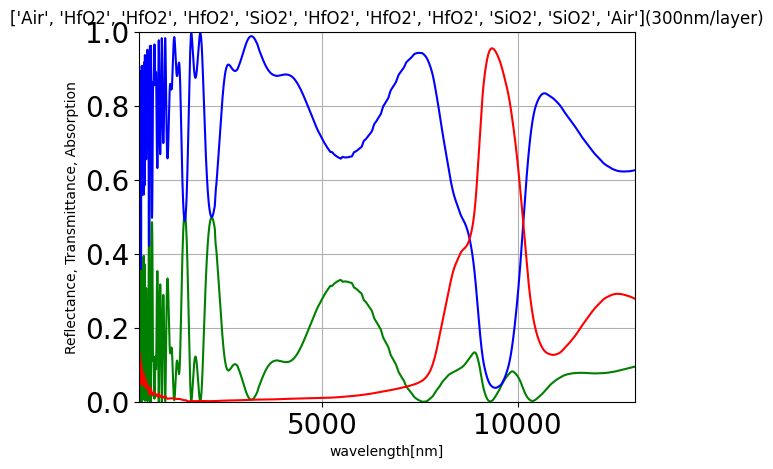

In [6]:
MIN3=300
MAX3=13000
DIV3 = MAX3-MIN3+1

x=[2, 2, 2, 1, 2, 2, 2, 1, 1]

STR=[]
d=[]
STR.append(FIRST_LAYER)
d.append(inf)
for i in range(LAYER):
    STR.append(int(x[i]))
    d.append(THICKNESS)
STR.append(LAST_LAYER)
d.append(inf)
print(STR,end=',')

n_list3=[]
MATERIAL=["Air","SiO2","HfO2","SiC"]
Material=[]
for i in range(len(MATERIAL)):
    Material.append(i)

#構造と屈折率から初期化
#print(STR)
Str,n_list3,n_dict3=init(MATERIAL,STR,d,MIN3,MAX3,DIV3)

Rs=[] 
Ts=[]
As=[]

for i in range(len(n_list3)):
    tmm3 = coh_tmm_s(n_list3[i][1:], n_dict3["d"], ANGLE, n_list3[i][0], Rs, Ts, As)


Figure, ax = plt.subplots()
plt.plot(n_list3[:,0],tmm3['Rs'],label='Rs',color='g')
plt.plot(n_list3[:,0],tmm3['Ts'],label='Ts',color='b')
plt.plot(n_list3[:,0],tmm3['As'],label='As',color='r')
#AM1.5
#print("AM1.5")
#energy_am = sum(AM_3_int)
#print(energy_am)
#AM1.5×吸収率
#print("AM1.5×吸収率")
#in_energy_am = sum(tmm1['As']*AM_3_int)
#print(in_energy_am)
ax.grid(True)
ax.set_xlim([MIN3,MAX3])
ax.set_ylim([0,1])
#ax.legend(fontsize=16, loc='upper left', bbox_to_anchor=(1, 1))
plt.tick_params(labelsize=20)
plt.xlabel('wavelength[nm]')
plt.ylabel('Reflectance, Transmittance, Absorption')
plt.title(str(Str)+'(300nm/layer)')
plt.show()


<br>SiO2のみの場合</br>

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],

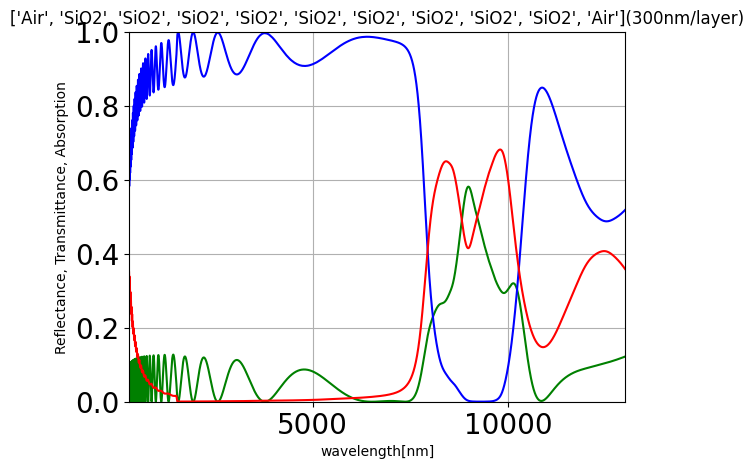

In [7]:
MIN4=300
MAX4=13000
DIV4 = MAX4-MIN4+1

x=[1, 1, 1, 1, 1, 1, 1, 1, 1]

STR=[]
d=[]
STR.append(FIRST_LAYER)
d.append(inf)
for i in range(LAYER):
    STR.append(int(x[i]))
    d.append(THICKNESS)
STR.append(LAST_LAYER)
d.append(inf)
print(STR,end=',')

n_list4=[]
Material=[]
for i in range(len(MATERIAL)):
    Material.append(i)

#構造と屈折率から初期化
#print(STR)
Str,n_list4,n_dict4=init(MATERIAL,STR,d,MIN4,MAX4,DIV4)

Rs=[] 
Ts=[]
As=[]

for i in range(len(n_list4)):
    tmm4 = coh_tmm_s(n_list4[i][1:], n_dict4["d"], ANGLE, n_list4[i][0], Rs, Ts, As)


Figure, ax = plt.subplots()
plt.plot(n_list3[:,0],tmm4['Rs'],label='Rs',color='g')
plt.plot(n_list3[:,0],tmm4['Ts'],label='Ts',color='b')
plt.plot(n_list3[:,0],tmm4['As'],label='As',color='r')
#AM1.5
#print("AM1.5")
#energy_am = sum(AM_3_int)
#print(energy_am)
#AM1.5×吸収率
#print("AM1.5×吸収率")
#in_energy_am = sum(tmm1['As']*AM_3_int)
#print(in_energy_am)
ax.grid(True)
ax.set_xlim([MIN3,MAX3])
ax.set_ylim([0,1])
#ax.legend(fontsize=16, loc='upper left', bbox_to_anchor=(1, 1))
plt.tick_params(labelsize=20)
plt.xlabel('wavelength[nm]')
plt.ylabel('Reflectance, Transmittance, Absorption')
plt.title(str(Str)+'(300nm/layer)')
plt.show()


透過型のものができた

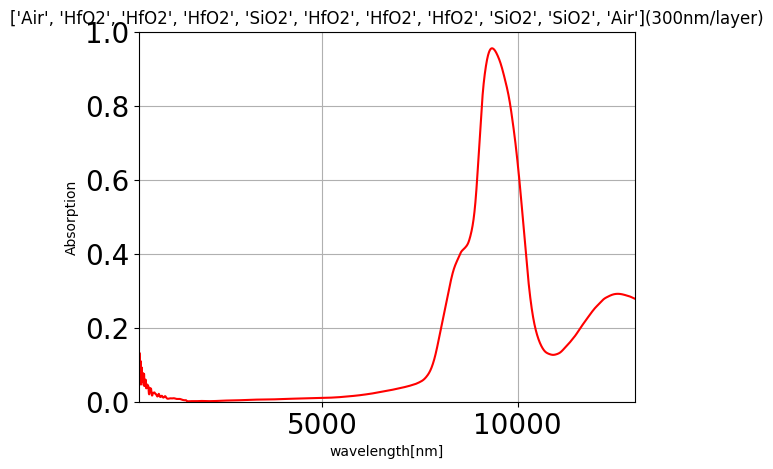

In [15]:
Figure, ax = plt.subplots()
plt.plot(n_list3[:,0],tmm3['As'],label='As',color='r')
#AM1.5
#print("AM1.5")
#energy_am = sum(AM_3_int)
#print(energy_am)
#AM1.5×吸収率
#print("AM1.5×吸収率")
#in_energy_am = sum(tmm1['As']*AM_3_int)
#print(in_energy_am)
ax.grid(True)
ax.set_xlim([MIN3,MAX3])
ax.set_ylim([0,1])
#ax.legend(fontsize=16, loc='upper left', bbox_to_anchor=(1, 1))
plt.tick_params(labelsize=20)
plt.xlabel('wavelength[nm]')
plt.ylabel('Absorption')
plt.title(str(Str)+'(300nm/layer)')
plt.show()

NameError: name 'n_list3' is not defined

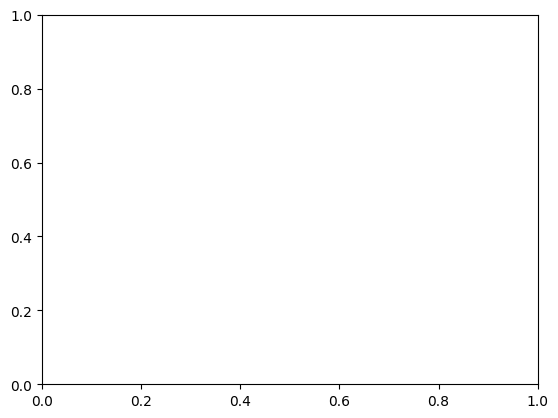

In [110]:
Figure, ax = plt.subplots()
plt.plot(n_list3[:,0],tmm3['As'],label='As',color='r')
#AM1.5
#print("AM1.5")
#energy_am = sum(AM_3_int)
#print(energy_am)
#AM1.5×吸収率
#print("AM1.5×吸収率")
#in_energy_am = sum(tmm1['As']*AM_3_int)
#print(in_energy_am)
ax.grid(True)
ax.set_xlim([300,4000])
ax.set_ylim([0,1])
#ax.legend(fontsize=16, loc='upper left', bbox_to_anchor=(1, 1))
plt.tick_params(labelsize=20)
plt.xlabel('wavelength[nm]')
plt.ylabel('Absorption')
plt.title(str(Str)+'(300nm/layer)')
plt.show()

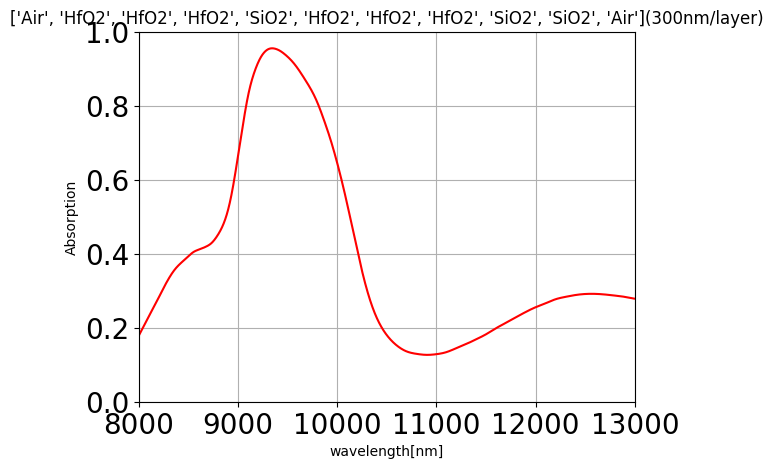

In [17]:
Figure, ax = plt.subplots()
plt.plot(n_list3[:,0],tmm3['As'],label='As',color='r')
#AM1.5
#print("AM1.5")
#energy_am = sum(AM_3_int)
#print(energy_am)
#AM1.5×吸収率
#print("AM1.5×吸収率")
#in_energy_am = sum(tmm1['As']*AM_3_int)
#print(in_energy_am)
ax.grid(True)
ax.set_xlim([8000,13000])
ax.set_ylim([0,1])
#ax.legend(fontsize=16, loc='upper left', bbox_to_anchor=(1, 1))
plt.tick_params(labelsize=20)
plt.xlabel('wavelength[nm]')
plt.ylabel('Absorption')
plt.title(str(Str)+'(300nm/layer)')
plt.show()

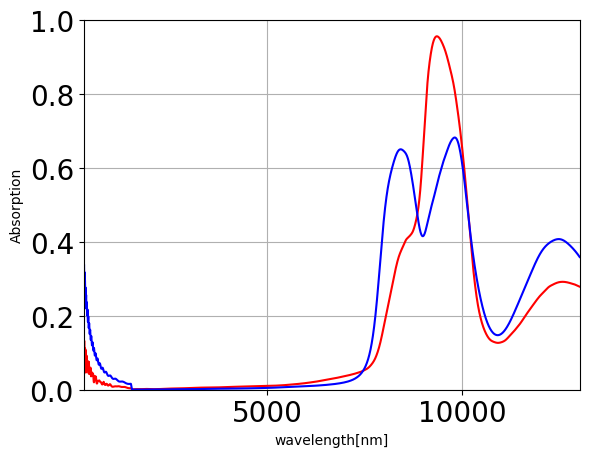

In [8]:
Figure, ax = plt.subplots()
plt.plot(n_list3[:,0],tmm3['As'],label='As',color='r')
plt.plot(n_list4[:,0],tmm4['As'],label='As',color='b')
#AM1.5
#print("AM1.5")
#energy_am = sum(AM_3_int)
#print(energy_am)
#AM1.5×吸収率
#print("AM1.5×吸収率")
#in_energy_am = sum(tmm1['As']*AM_3_int)
#print(in_energy_am)
ax.grid(True)
ax.set_xlim([MIN3,MAX3])
ax.set_ylim([0,1])
#ax.legend(fontsize=16, loc='upper left', bbox_to_anchor=(1, 1))
plt.tick_params(labelsize=20)
plt.xlabel('wavelength[nm]')
plt.ylabel('Absorption')
plt.title('')
plt.show()

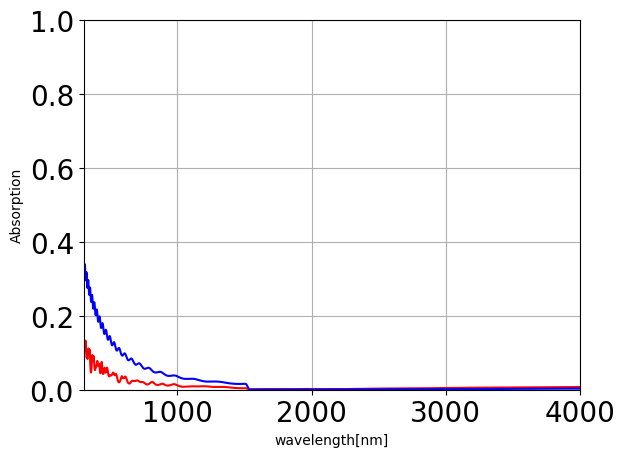

In [9]:
Figure, ax = plt.subplots()
plt.plot(n_list3[:,0],tmm3['As'],label='As',color='r')
plt.plot(n_list4[:,0],tmm4['As'],label='As',color='b')
#AM1.5
#print("AM1.5")
#energy_am = sum(AM_3_int)
#print(energy_am)
#AM1.5×吸収率
#print("AM1.5×吸収率")
#in_energy_am = sum(tmm1['As']*AM_3_int)
#print(in_energy_am)
ax.grid(True)
ax.set_xlim([300,4000])
ax.set_ylim([0,1])
#ax.legend(fontsize=16, loc='upper left', bbox_to_anchor=(1, 1))
plt.tick_params(labelsize=20)
plt.xlabel('wavelength[nm]')
plt.ylabel('Absorption')
plt.title('')
plt.show()

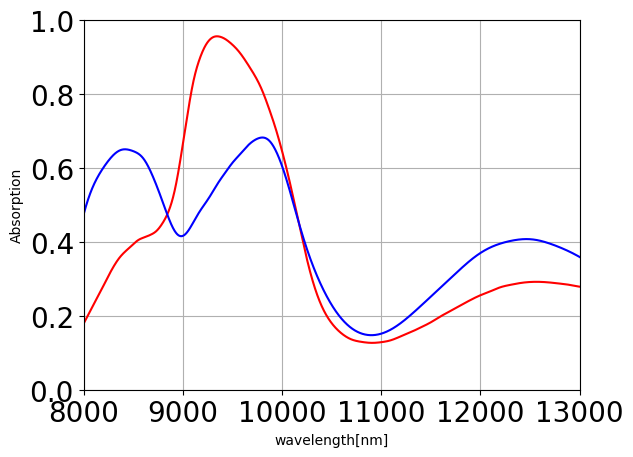

In [10]:
Figure, ax = plt.subplots()
plt.plot(n_list3[:,0],tmm3['As'],label='As',color='r')
plt.plot(n_list4[:,0],tmm4['As'],label='As',color='b')
#AM1.5
#print("AM1.5")
#energy_am = sum(AM_3_int)
#print(energy_am)
#AM1.5×吸収率
#print("AM1.5×吸収率")
#in_energy_am = sum(tmm1['As']*AM_3_int)
#print(in_energy_am)
ax.grid(True)
ax.set_xlim([8000,13000])
ax.set_ylim([0,1])
#ax.legend(fontsize=16, loc='upper left', bbox_to_anchor=(1, 1))
plt.tick_params(labelsize=20)
plt.xlabel('wavelength[nm]')
plt.ylabel('Absorption')
plt.title('')
plt.show()

SiO21層との比較用スペクトル

[0, 1, 0],

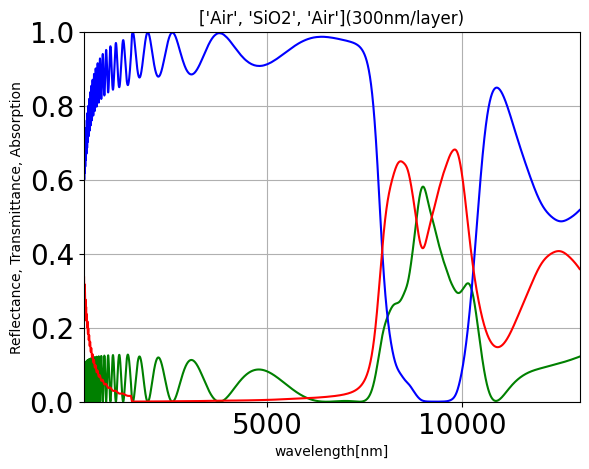

In [14]:
MIN4=300
MAX4=13000
DIV4 = MAX4-MIN4+1
LAYER=1
THICKNESS=2700
x=[1]

STR=[]
d=[]
STR.append(FIRST_LAYER)
d.append(inf)
for i in range(LAYER):
    STR.append(int(x[i]))
    d.append(THICKNESS)
STR.append(LAST_LAYER)
d.append(inf)
print(STR,end=',')

n_list4=[]
Material=[]
for i in range(len(MATERIAL)):
    Material.append(i)

#構造と屈折率から初期化
#print(STR)
Str,n_list4,n_dict4=init(MATERIAL,STR,d,MIN4,MAX4,DIV4)

Rs=[] 
Ts=[]
As=[]

for i in range(len(n_list4)):
    tmm4 = coh_tmm_s(n_list4[i][1:], n_dict4["d"], ANGLE, n_list4[i][0], Rs, Ts, As)


Figure, ax = plt.subplots()
plt.plot(n_list3[:,0],tmm4['Rs'],label='Rs',color='g')
plt.plot(n_list3[:,0],tmm4['Ts'],label='Ts',color='b')
plt.plot(n_list3[:,0],tmm4['As'],label='As',color='r')
#AM1.5
#print("AM1.5")
#energy_am = sum(AM_3_int)
#print(energy_am)
#AM1.5×吸収率
#print("AM1.5×吸収率")
#in_energy_am = sum(tmm1['As']*AM_3_int)
#print(in_energy_am)
ax.grid(True)
ax.set_xlim([MIN3,MAX3])
ax.set_ylim([0,1])
#ax.legend(fontsize=16, loc='upper left', bbox_to_anchor=(1, 1))
plt.tick_params(labelsize=20)
plt.xlabel('wavelength[nm]')
plt.ylabel('Reflectance, Transmittance, Absorption')
plt.title(str(Str)+'(300nm/layer)')
plt.show()


SiO29層でも1層でも同じ厚さであれば同じスペクトルが得られることが分かった。

In [12]:
import pickle
STR_opt=[0, 2, 2, 2, 1, 2, 2, 2, 1, 1, 0]
THICKNESS=300

f = open('C:/Users/tsune/Desktop/'+str(len(STR_opt)-2)+'layer_'+str(THICKNESS)+'nm/'+str(STR_opt), 'rb')
data=pickle.load(f)
in_energy_am=data["in"]
out_energy_bb=data["out"]
f.close
print(f'{in_energy_am} [W/m^2]')
print(f'{out_energy_bb} [W/m^2]')

21.645549507760794 [W/m^2]
59.20383979732185 [W/m^2]


In [13]:
import pickle
STR_opt=[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
THICKNESS=300

f = open('C:/Users/tsune/Desktop/'+str(len(STR_opt)-2)+'layer_'+str(THICKNESS)+'nm/'+str(STR_opt), 'rb')
data=pickle.load(f)
in_energy_am=data["in"]
out_energy_bb=data["out"]
f.close
print(f'{in_energy_am} [W/m^2]')
print(f'{out_energy_bb} [W/m^2]')

68.0216313338085 [W/m^2]
61.88619249020134 [W/m^2]


ベイズ最適化

In [36]:
def fom(x):
    
    STR=[]
    d=[]
    STR.append(FIRST_LAYER)
    d.append(inf)
    for i in range(LAYER):
        STR.append(int(x[0,i]))
        d.append(THICKNESS)
    STR.append(LAST_LAYER)
    d.append(inf)
    print(STR,end=',')
    
    n_list1=[]
    MATERIAL=["Air","SiO2","HfO2","SiC"]
    Material=[]
    for i in range(len(MATERIAL)):
        Material.append(i)

    #構造と屈折率から初期化
    #print(STR)
    Str,n_list1,n_dict1=init(MATERIAL,STR,d,MIN1,MAX1,DIV1)

    Rs=[] 
    Ts=[]
    As=[]

    for i in range(len(n_list1)):
        tmm1 = coh_tmm_s(n_list1[i][1:], n_dict1["d"], ANGLE, n_list1[i][0], Rs, Ts, As)
    
    #AM1.5から吸収されるエネルギー
    in_energy_am = sum(tmm1['As']*AM_3_int)    
    
    #BB
    n_list2=[]

    #構造と屈折率から初期化
    #print(STR)
    Str,n_list2,n_dict2=init(MATERIAL,STR,d,MIN2,MAX2,DIV2)

    Rs=[] 
    Ts=[]
    As=[]

    for j in range(len(n_list2)):
        tmm2 = coh_tmm_s(n_list2[j][1:], n_dict2["d"], ANGLE, n_list2[j][0], Rs, Ts, As)
    
    #黒体放射で放射されるエネルギー
    out_energy_bb = sum(tmm2['As']*intensity_watt)
    
    print(f'{in_energy_am-out_energy_bb} [W/m^2]')

    return in_energy_am-out_energy_bb

def fom_pickle(x):
    
    STR=[]
    STR.append(FIRST_LAYER)
    for i in range(LAYER):
        STR.append(int(x[0,i]))
    STR.append(LAST_LAYER)
    print(STR,end=',')

    f = open('C:/Users/tsune/Desktop/'+str(len(x[0,:]))+'layer_'+str(THICKNESS)+'nm/'+str(STR), 'rb')
    data=pickle.load(f)
    in_energy_am=data["in"]
    out_energy_bb=data["out"]
    f.close
    
    print(f'{in_energy_am-out_energy_bb} [W/m^2]')

    return in_energy_am-out_energy_bb

In [28]:
#シミュレーション条件
LAYER = 9
THICKNESS = 300
ANGLE = 0
FIRST_LAYER = 0
LAST_LAYER = 0
INITIAL = 80
MAX_ITER = 1000
AQUISITION_TYPE='LCB'
BETA=5
#材質の種類
Air=1
SiO2="C:/Users/tsune/Desktop/SiO2_nk_0.03_50.csv"
HfO2="C:/Users/tsune/Desktop/HfO2_nk_0.2_500.csv"
AlN="C:/Users/tsune/Desktop/AlN_nk_0.211_20.csv"
Al="C:/Users/tsune/Desktop/Al_nk_0.062_248.csv"
Ag="C:/Users/tsune/Desktop/Ag_nk_0.27_24.9.csv"
SiC="C:/Users/tsune/Desktop/SiC_nk_0.006154_131.7.csv"
#MATERIAL=["Air","Ag","Au","SiO2"]
MATERIAL=["Air","SiO2","HfO2","SiC"]

Material=[]
for i in range(len(MATERIAL)):
    Material.append(i)
#設定表示
print('構造 : '+MATERIAL[FIRST_LAYER]+'-'+'X-'*LAYER+MATERIAL[LAST_LAYER]+' (X=',end='')
for i in range(len(MATERIAL)-2):
    print(MATERIAL[i+1],end=',')
print(MATERIAL[len(MATERIAL)-1]+')')
print('厚さ : '+str(THICKNESS)+'[nm] (1層あたり)')
print('総数 : '+str((len(MATERIAL)-1)**LAYER)+'通り')
#print('波長 : '+str(MIN)+'[nm]～'+str(MAX)+'[nm] ('+str(DIV)+'分割)')
print('入射角 : '+str(ANGLE)+'°固定')
print('初期サンプリング数 : '+str(INITIAL))
print('最大イテレーション : '+str(MAX_ITER))
print('獲得関数 : '+str(AQUISITION_TYPE))
print('β : ',BETA)

print('\n')
#設定表示
print('Structure : '+MATERIAL[FIRST_LAYER]+'-'+'X-'*LAYER+MATERIAL[LAST_LAYER]+' (X=',end='')
for i in range(len(MATERIAL)-2):
    print(MATERIAL[i+1],end=',')
print(MATERIAL[len(MATERIAL)-1]+')')
print('Thickness : '+str(THICKNESS)+'[nm] (/layer)')
print('Pattern : '+str((len(MATERIAL)-1)**LAYER)+'pttern')
#print('Wavelength : '+str(MIN)+'[nm]～'+str(MAX)+'[nm] ('+str(DIV)+'divitions)')
print('Angle : '+str(ANGLE)+'°fixed')
print('Initial sampling : '+str(INITIAL))
print('Max iteration : '+str(MAX_ITER))
print('Aquisition function : '+str(AQUISITION_TYPE))
print('β : ',BETA)

#AM1.5
MIN1 = 300
MAX1 = 4000
DIV1 = MAX1-MIN1+1
latent=np.linspace(MIN1,MAX1,DIV1)
#AM1.5のデータをCSVから読み込み1次元配列として格納
AM15=np.loadtxt("C:/Users/tsune/Desktop/AM1.5.csv",skiprows=0, delimiter=',')
AM_WL=AM15.T[0]
AM_3=AM15.T[3]
#AM1.5のデータを補間
AM_3_int=cubic(AM_WL,AM_3,latent)

energy_am = sum(AM_3_int)
print(energy_am)

#BB
MIN2=8000
MAX2=13000
DIV2 = MAX2-MIN2+1

# Plot blackbody radiation spectrum for various temperatures
wavelengths2 = np.linspace(MIN2/1e9, MAX2/1e9, DIV2) # Wavelength range in meters

T=300
#黒体放射のエネルギースペクトル計算
intensity = planck(wavelengths2, T)

"""
Figure, ax = plt.subplots()
plt.plot(wavelengths2 * 1e9, intensity/1e9, label=f'T = {T} K')
ax.set_xlim([MIN2,MAX2])
#ax.set_ylim([0,0.01])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (W/sr/m^2/nm)')
plt.legend()
plt.title(f'Blackbody Radiation Spectrum{MIN2/1000}μm~{MAX2/1000}μm')
plt.show()
"""

intensity_watt = intensity*3.14/1e9
energy_bb = sum(intensity_watt)
print(f'総エネルギー:{energy_bb}[W]')

構造 : Air-X-X-X-X-X-X-X-X-X-Air (X=SiO2,HfO2,SiC)
厚さ : 300[nm] (1層あたり)
総数 : 19683通り
入射角 : 0°固定
初期サンプリング数 : 80
最大イテレーション : 1000
獲得関数 : LCB
β :  5


Structure : Air-X-X-X-X-X-X-X-X-X-Air (X=SiO2,HfO2,SiC)
Thickness : 300[nm] (/layer)
Pattern : 19683pttern
Angle : 0°fixed
Initial sampling : 80
Max iteration : 1000
Aquisition function : LCB
β :  5
900.1350327626734
総エネルギー:147.9169733484078[W]


In [31]:
bounds=[]
for i in range(LAYER):
    bounds.append({'name': 'x1', 'type': 'discrete', 'domain': np.linspace(1,len(MATERIAL)-1,len(MATERIAL)-1)})
print('\n初期サンプリング\n')
myBopt = GPyOpt.methods.BayesianOptimization(f=fom,acquisition_weight=BETA, domain=bounds,initial_design_numdata=INITIAL,acquisition_type=AQUISITION_TYPE)


初期サンプリング

[0, 2, 2, 2, 2, 1, 2, 2, 2, 3, 0],382.3964244730327 [W/m^2]
[0, 2, 2, 1, 1, 2, 2, 1, 3, 1, 0],322.3251364479938 [W/m^2]
[0, 2, 1, 3, 1, 1, 2, 2, 3, 1, 0],408.5434064425545 [W/m^2]
[0, 2, 2, 3, 1, 1, 3, 3, 2, 1, 0],489.79425637459536 [W/m^2]
[0, 2, 1, 1, 3, 2, 2, 3, 2, 2, 0],428.55485665961334 [W/m^2]
[0, 1, 3, 1, 2, 2, 2, 1, 1, 2, 0],393.6639705076045 [W/m^2]
[0, 2, 3, 2, 1, 1, 3, 2, 1, 3, 0],498.8917047940006 [W/m^2]
[0, 3, 1, 3, 2, 3, 1, 1, 2, 1, 0],419.66424198000396 [W/m^2]
[0, 3, 3, 1, 3, 3, 3, 3, 3, 3, 0],469.9541540890801 [W/m^2]
[0, 2, 3, 2, 1, 3, 3, 3, 3, 1, 0],521.2322591222894 [W/m^2]
[0, 1, 2, 2, 3, 1, 2, 3, 2, 1, 0],496.3891252243632 [W/m^2]
[0, 3, 1, 2, 2, 1, 3, 3, 2, 1, 0],392.64281804263294 [W/m^2]
[0, 1, 2, 3, 3, 2, 2, 2, 1, 1, 0],521.1408729179191 [W/m^2]
[0, 2, 1, 3, 3, 2, 3, 1, 1, 2, 0],468.55120514490875 [W/m^2]
[0, 2, 2, 1, 2, 1, 1, 2, 3, 3, 0],428.2210181340539 [W/m^2]
[0, 2, 1, 3, 3, 3, 3, 3, 3, 3, 0],518.344716958263 [W/m^2]
[0, 2, 1, 2, 3, 2, 3, 2, 

In [32]:
print('\n最適化開始\n')
myBopt.run_optimization(max_iter=MAX_ITER, verbosity=True)
print('\n最適化終了\n')


最適化開始

[0, 1, 2, 1, 1, 2, 1, 1, 1, 1, 0],-16.519079787579976 [W/m^2]
num acquisition: 1, time elapsed: 5.67s
[0, 1, 2, 1, 1, 1, 1, 1, 1, 2, 0],-8.032563022043739 [W/m^2]
num acquisition: 2, time elapsed: 11.04s
[0, 2, 1, 1, 1, 2, 1, 1, 1, 2, 0],-14.610701983825969 [W/m^2]
num acquisition: 3, time elapsed: 16.73s
[0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0],-10.561168339876446 [W/m^2]
num acquisition: 4, time elapsed: 22.19s
[0, 1, 1, 1, 1, 2, 1, 1, 1, 2, 0],1.0862681728162968 [W/m^2]
num acquisition: 5, time elapsed: 28.04s
[0, 2, 2, 1, 1, 2, 1, 1, 1, 2, 0],-24.345211094975156 [W/m^2]
num acquisition: 6, time elapsed: 34.14s
[0, 2, 2, 1, 1, 2, 1, 1, 2, 1, 0],-27.384077480702395 [W/m^2]
num acquisition: 7, time elapsed: 39.86s
[0, 2, 1, 1, 1, 2, 1, 1, 1, 1, 0],-17.257056117185854 [W/m^2]
num acquisition: 8, time elapsed: 45.69s
[0, 3, 2, 1, 1, 1, 1, 1, 1, 1, 0],297.5439904070528 [W/m^2]
num acquisition: 9, time elapsed: 51.71s
[0, 1, 2, 1, 1, 1, 1, 1, 2, 1, 0],-11.59942763599851 [W/m^2]
num acqui

In [37]:
#シミュレーション条件
LAYER = 9
THICKNESS = 300
ANGLE = 0
FIRST_LAYER = 0
LAST_LAYER = 0
INITIAL = 80
MAX_ITER = 1000
AQUISITION_TYPE='LCB'
BETA=5
#材質の種類
Air=1
SiO2="C:/Users/tsune/Desktop/SiO2_nk_0.03_50.csv"
HfO2="C:/Users/tsune/Desktop/HfO2_nk_0.2_500.csv"
AlN="C:/Users/tsune/Desktop/AlN_nk_0.211_20.csv"
Al="C:/Users/tsune/Desktop/Al_nk_0.062_248.csv"
Ag="C:/Users/tsune/Desktop/Ag_nk_0.27_24.9.csv"
SiC="C:/Users/tsune/Desktop/SiC_nk_0.006154_131.7.csv"
#MATERIAL=["Air","Ag","Au","SiO2"]
MATERIAL=["Air","SiO2","HfO2","SiC"]

Material=[]
for i in range(len(MATERIAL)):
    Material.append(i)
#設定表示
print('構造 : '+MATERIAL[FIRST_LAYER]+'-'+'X-'*LAYER+MATERIAL[LAST_LAYER]+' (X=',end='')
for i in range(len(MATERIAL)-2):
    print(MATERIAL[i+1],end=',')
print(MATERIAL[len(MATERIAL)-1]+')')
print('厚さ : '+str(THICKNESS)+'[nm] (1層あたり)')
print('総数 : '+str((len(MATERIAL)-1)**LAYER)+'通り')
#print('波長 : '+str(MIN)+'[nm]～'+str(MAX)+'[nm] ('+str(DIV)+'分割)')
print('入射角 : '+str(ANGLE)+'°固定')
print('初期サンプリング数 : '+str(INITIAL))
print('最大イテレーション : '+str(MAX_ITER))
print('獲得関数 : '+str(AQUISITION_TYPE))
print('β : ',BETA)

print('\n')
#設定表示
print('Structure : '+MATERIAL[FIRST_LAYER]+'-'+'X-'*LAYER+MATERIAL[LAST_LAYER]+' (X=',end='')
for i in range(len(MATERIAL)-2):
    print(MATERIAL[i+1],end=',')
print(MATERIAL[len(MATERIAL)-1]+')')
print('Thickness : '+str(THICKNESS)+'[nm] (/layer)')
print('Pattern : '+str((len(MATERIAL)-1)**LAYER)+'pttern')
#print('Wavelength : '+str(MIN)+'[nm]～'+str(MAX)+'[nm] ('+str(DIV)+'divitions)')
print('Angle : '+str(ANGLE)+'°fixed')
print('Initial sampling : '+str(INITIAL))
print('Max iteration : '+str(MAX_ITER))
print('Aquisition function : '+str(AQUISITION_TYPE))
print('β : ',BETA)

#AM1.5
MIN1 = 300
MAX1 = 4000
DIV1 = MAX1-MIN1+1
latent=np.linspace(MIN1,MAX1,DIV1)
#AM1.5のデータをCSVから読み込み1次元配列として格納
AM15=np.loadtxt("C:/Users/tsune/Desktop/AM1.5.csv",skiprows=0, delimiter=',')
AM_WL=AM15.T[0]
AM_3=AM15.T[3]
#AM1.5のデータを補間
AM_3_int=cubic(AM_WL,AM_3,latent)

energy_am = sum(AM_3_int)
print(energy_am)

#BB
MIN2=8000
MAX2=13000
DIV2 = MAX2-MIN2+1

# Plot blackbody radiation spectrum for various temperatures
wavelengths2 = np.linspace(MIN2/1e9, MAX2/1e9, DIV2) # Wavelength range in meters

T=300
#黒体放射のエネルギースペクトル計算
intensity = planck(wavelengths2, T)

"""
Figure, ax = plt.subplots()
plt.plot(wavelengths2 * 1e9, intensity/1e9, label=f'T = {T} K')
ax.set_xlim([MIN2,MAX2])
#ax.set_ylim([0,0.01])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (W/sr/m^2/nm)')
plt.legend()
plt.title(f'Blackbody Radiation Spectrum{MIN2/1000}μm~{MAX2/1000}μm')
plt.show()
"""

intensity_watt = intensity*3.14/1e9
energy_bb = sum(intensity_watt)
print(f'総エネルギー:{energy_bb}[W]')

bounds=[]
for i in range(LAYER):
    bounds.append({'name': 'x1', 'type': 'discrete', 'domain': np.linspace(1,len(MATERIAL)-1,len(MATERIAL)-1)})
print('\n初期サンプリング\n')
myBopt = GPyOpt.methods.BayesianOptimization(f=fom_pickle,acquisition_weight=BETA, domain=bounds,initial_design_numdata=INITIAL,acquisition_type=AQUISITION_TYPE)

print('\n最適化開始\n')
myBopt.run_optimization(max_iter=MAX_ITER, verbosity=True)
print('\n最適化終了\n')

構造 : Air-X-X-X-X-X-X-X-X-X-Air (X=SiO2,HfO2,SiC)
厚さ : 300[nm] (1層あたり)
総数 : 19683通り
入射角 : 0°固定
初期サンプリング数 : 80
最大イテレーション : 1000
獲得関数 : LCB
β :  5


Structure : Air-X-X-X-X-X-X-X-X-X-Air (X=SiO2,HfO2,SiC)
Thickness : 300[nm] (/layer)
Pattern : 19683pttern
Angle : 0°fixed
Initial sampling : 80
Max iteration : 1000
Aquisition function : LCB
β :  5
900.1350327626734
総エネルギー:147.9169733484078[W]

初期サンプリング

[0, 1, 2, 2, 1, 3, 3, 2, 1, 3, 0],486.9414193163092 [W/m^2]
[0, 2, 1, 1, 1, 3, 2, 3, 1, 2, 0],432.30269314604607 [W/m^2]
[0, 1, 1, 1, 1, 2, 2, 3, 3, 1, 0],513.3867843913688 [W/m^2]
[0, 2, 2, 3, 3, 3, 2, 3, 3, 3, 0],571.6263792535574 [W/m^2]
[0, 3, 1, 1, 2, 2, 1, 3, 1, 3, 0],411.06696650541164 [W/m^2]
[0, 3, 1, 1, 2, 3, 3, 1, 3, 2, 0],420.64854347049646 [W/m^2]
[0, 1, 3, 2, 2, 1, 1, 1, 3, 2, 0],449.73915467933784 [W/m^2]
[0, 2, 1, 2, 2, 3, 1, 1, 2, 2, 0],384.4862484794483 [W/m^2]
[0, 3, 1, 3, 1, 1, 1, 1, 2, 1, 0],385.8509631290355 [W/m^2]
[0, 3, 1, 1, 1, 2, 3, 1, 1, 3, 0],413.1042747409546 [W

In [38]:
#シミュレーション条件
LAYER = 9
THICKNESS = 300
ANGLE = 0
FIRST_LAYER = 0
LAST_LAYER = 0
INITIAL = 80
MAX_ITER = 1000
AQUISITION_TYPE='LCB'
BETA=5
#材質の種類
Air=1
SiO2="C:/Users/tsune/Desktop/SiO2_nk_0.03_50.csv"
HfO2="C:/Users/tsune/Desktop/HfO2_nk_0.2_500.csv"
AlN="C:/Users/tsune/Desktop/AlN_nk_0.211_20.csv"
Al="C:/Users/tsune/Desktop/Al_nk_0.062_248.csv"
Ag="C:/Users/tsune/Desktop/Ag_nk_0.27_24.9.csv"
SiC="C:/Users/tsune/Desktop/SiC_nk_0.006154_131.7.csv"
#MATERIAL=["Air","Ag","Au","SiO2"]
MATERIAL=["Air","SiO2","HfO2","SiC"]

Material=[]
for i in range(len(MATERIAL)):
    Material.append(i)
#設定表示
print('構造 : '+MATERIAL[FIRST_LAYER]+'-'+'X-'*LAYER+MATERIAL[LAST_LAYER]+' (X=',end='')
for i in range(len(MATERIAL)-2):
    print(MATERIAL[i+1],end=',')
print(MATERIAL[len(MATERIAL)-1]+')')
print('厚さ : '+str(THICKNESS)+'[nm] (1層あたり)')
print('総数 : '+str((len(MATERIAL)-1)**LAYER)+'通り')
#print('波長 : '+str(MIN)+'[nm]～'+str(MAX)+'[nm] ('+str(DIV)+'分割)')
print('入射角 : '+str(ANGLE)+'°固定')
print('初期サンプリング数 : '+str(INITIAL))
print('最大イテレーション : '+str(MAX_ITER))
print('獲得関数 : '+str(AQUISITION_TYPE))
print('β : ',BETA)

print('\n')
#設定表示
print('Structure : '+MATERIAL[FIRST_LAYER]+'-'+'X-'*LAYER+MATERIAL[LAST_LAYER]+' (X=',end='')
for i in range(len(MATERIAL)-2):
    print(MATERIAL[i+1],end=',')
print(MATERIAL[len(MATERIAL)-1]+')')
print('Thickness : '+str(THICKNESS)+'[nm] (/layer)')
print('Pattern : '+str((len(MATERIAL)-1)**LAYER)+'pttern')
#print('Wavelength : '+str(MIN)+'[nm]～'+str(MAX)+'[nm] ('+str(DIV)+'divitions)')
print('Angle : '+str(ANGLE)+'°fixed')
print('Initial sampling : '+str(INITIAL))
print('Max iteration : '+str(MAX_ITER))
print('Aquisition function : '+str(AQUISITION_TYPE))
print('β : ',BETA)

#AM1.5
MIN1 = 300
MAX1 = 4000
DIV1 = MAX1-MIN1+1
latent=np.linspace(MIN1,MAX1,DIV1)
#AM1.5のデータをCSVから読み込み1次元配列として格納
AM15=np.loadtxt("C:/Users/tsune/Desktop/AM1.5.csv",skiprows=0, delimiter=',')
AM_WL=AM15.T[0]
AM_3=AM15.T[3]
#AM1.5のデータを補間
AM_3_int=cubic(AM_WL,AM_3,latent)

energy_am = sum(AM_3_int)
print(energy_am)

#BB
MIN2=8000
MAX2=13000
DIV2 = MAX2-MIN2+1

# Plot blackbody radiation spectrum for various temperatures
wavelengths2 = np.linspace(MIN2/1e9, MAX2/1e9, DIV2) # Wavelength range in meters

T=300
#黒体放射のエネルギースペクトル計算
intensity = planck(wavelengths2, T)

"""
Figure, ax = plt.subplots()
plt.plot(wavelengths2 * 1e9, intensity/1e9, label=f'T = {T} K')
ax.set_xlim([MIN2,MAX2])
#ax.set_ylim([0,0.01])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (W/sr/m^2/nm)')
plt.legend()
plt.title(f'Blackbody Radiation Spectrum{MIN2/1000}μm~{MAX2/1000}μm')
plt.show()
"""

intensity_watt = intensity*3.14/1e9
energy_bb = sum(intensity_watt)
print(f'総エネルギー:{energy_bb}[W]')

bounds=[]
for i in range(LAYER):
    bounds.append({'name': 'x1', 'type': 'discrete', 'domain': np.linspace(1,len(MATERIAL)-1,len(MATERIAL)-1)})
print('\n初期サンプリング\n')
myBopt = GPyOpt.methods.BayesianOptimization(f=fom_pickle,acquisition_weight=BETA, domain=bounds,initial_design_numdata=INITIAL,acquisition_type=AQUISITION_TYPE)

print('\n最適化開始\n')
myBopt.run_optimization(max_iter=MAX_ITER, verbosity=True)
print('\n最適化終了\n')

構造 : Air-X-X-X-X-X-X-X-X-X-Air (X=SiO2,HfO2,SiC)
厚さ : 300[nm] (1層あたり)
総数 : 19683通り
入射角 : 0°固定
初期サンプリング数 : 80
最大イテレーション : 1000
獲得関数 : LCB
β :  5


Structure : Air-X-X-X-X-X-X-X-X-X-Air (X=SiO2,HfO2,SiC)
Thickness : 300[nm] (/layer)
Pattern : 19683pttern
Angle : 0°fixed
Initial sampling : 80
Max iteration : 1000
Aquisition function : LCB
β :  5
900.1350327626734
総エネルギー:147.9169733484078[W]

初期サンプリング

[0, 2, 1, 3, 2, 1, 2, 1, 3, 1, 0],408.2894128441118 [W/m^2]
[0, 1, 3, 3, 2, 1, 3, 2, 1, 1, 0],507.54838872067023 [W/m^2]
[0, 2, 3, 2, 1, 1, 2, 1, 2, 2, 0],399.75730015811837 [W/m^2]
[0, 1, 2, 2, 3, 2, 2, 3, 1, 1, 0],507.26872274192476 [W/m^2]
[0, 1, 3, 1, 3, 1, 1, 3, 1, 2, 0],488.67408822955105 [W/m^2]
[0, 1, 1, 3, 3, 2, 2, 3, 3, 3, 0],549.2512208296175 [W/m^2]
[0, 2, 3, 1, 3, 2, 1, 2, 3, 2, 0],510.5089710677183 [W/m^2]
[0, 2, 2, 1, 1, 1, 3, 3, 1, 3, 0],454.7450645087049 [W/m^2]
[0, 2, 3, 2, 3, 2, 2, 1, 1, 1, 0],483.55681748700795 [W/m^2]
[0, 1, 3, 3, 2, 1, 3, 3, 2, 2, 0],524.3988881947279 [

In [43]:
#シミュレーション条件
LAYER = 9
THICKNESS = 300
ANGLE = 0
FIRST_LAYER = 0
LAST_LAYER = 0
INITIAL = 100
MAX_ITER = 1000
AQUISITION_TYPE='LCB'
BETA=50
#材質の種類
Air=1
SiO2="C:/Users/tsune/Desktop/SiO2_nk_0.03_50.csv"
HfO2="C:/Users/tsune/Desktop/HfO2_nk_0.2_500.csv"
AlN="C:/Users/tsune/Desktop/AlN_nk_0.211_20.csv"
Al="C:/Users/tsune/Desktop/Al_nk_0.062_248.csv"
Ag="C:/Users/tsune/Desktop/Ag_nk_0.27_24.9.csv"
SiC="C:/Users/tsune/Desktop/SiC_nk_0.006154_131.7.csv"
#MATERIAL=["Air","Ag","Au","SiO2"]
MATERIAL=["Air","SiO2","HfO2","SiC"]

Material=[]
for i in range(len(MATERIAL)):
    Material.append(i)
#設定表示
print('構造 : '+MATERIAL[FIRST_LAYER]+'-'+'X-'*LAYER+MATERIAL[LAST_LAYER]+' (X=',end='')
for i in range(len(MATERIAL)-2):
    print(MATERIAL[i+1],end=',')
print(MATERIAL[len(MATERIAL)-1]+')')
print('厚さ : '+str(THICKNESS)+'[nm] (1層あたり)')
print('総数 : '+str((len(MATERIAL)-1)**LAYER)+'通り')
#print('波長 : '+str(MIN)+'[nm]～'+str(MAX)+'[nm] ('+str(DIV)+'分割)')
print('入射角 : '+str(ANGLE)+'°固定')
print('初期サンプリング数 : '+str(INITIAL))
print('最大イテレーション : '+str(MAX_ITER))
print('獲得関数 : '+str(AQUISITION_TYPE))
print('β : ',BETA)

print('\n')
#設定表示
print('Structure : '+MATERIAL[FIRST_LAYER]+'-'+'X-'*LAYER+MATERIAL[LAST_LAYER]+' (X=',end='')
for i in range(len(MATERIAL)-2):
    print(MATERIAL[i+1],end=',')
print(MATERIAL[len(MATERIAL)-1]+')')
print('Thickness : '+str(THICKNESS)+'[nm] (/layer)')
print('Pattern : '+str((len(MATERIAL)-1)**LAYER)+'pttern')
#print('Wavelength : '+str(MIN)+'[nm]～'+str(MAX)+'[nm] ('+str(DIV)+'divitions)')
print('Angle : '+str(ANGLE)+'°fixed')
print('Initial sampling : '+str(INITIAL))
print('Max iteration : '+str(MAX_ITER))
print('Aquisition function : '+str(AQUISITION_TYPE))
print('β : ',BETA)

#AM1.5
MIN1 = 300
MAX1 = 4000
DIV1 = MAX1-MIN1+1
latent=np.linspace(MIN1,MAX1,DIV1)
#AM1.5のデータをCSVから読み込み1次元配列として格納
AM15=np.loadtxt("C:/Users/tsune/Desktop/AM1.5.csv",skiprows=0, delimiter=',')
AM_WL=AM15.T[0]
AM_3=AM15.T[3]
#AM1.5のデータを補間
AM_3_int=cubic(AM_WL,AM_3,latent)

energy_am = sum(AM_3_int)
print(energy_am)

#BB
MIN2=8000
MAX2=13000
DIV2 = MAX2-MIN2+1

# Plot blackbody radiation spectrum for various temperatures
wavelengths2 = np.linspace(MIN2/1e9, MAX2/1e9, DIV2) # Wavelength range in meters

T=300
#黒体放射のエネルギースペクトル計算
intensity = planck(wavelengths2, T)

"""
Figure, ax = plt.subplots()
plt.plot(wavelengths2 * 1e9, intensity/1e9, label=f'T = {T} K')
ax.set_xlim([MIN2,MAX2])
#ax.set_ylim([0,0.01])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (W/sr/m^2/nm)')
plt.legend()
plt.title(f'Blackbody Radiation Spectrum{MIN2/1000}μm~{MAX2/1000}μm')
plt.show()
"""

intensity_watt = intensity*3.14/1e9
energy_bb = sum(intensity_watt)
print(f'総エネルギー:{energy_bb}[W]')

bounds=[]
for i in range(LAYER):
    bounds.append({'name': 'x1', 'type': 'discrete', 'domain': np.linspace(1,len(MATERIAL)-1,len(MATERIAL)-1)})
print('\n初期サンプリング\n')
myBopt = GPyOpt.methods.BayesianOptimization(f=fom_pickle,acquisition_weight=BETA, domain=bounds,initial_design_numdata=INITIAL,acquisition_type=AQUISITION_TYPE)

print('\n最適化開始\n')
myBopt.run_optimization(max_iter=MAX_ITER, verbosity=True)
print('\n最適化終了\n')

構造 : Air-X-X-X-X-X-X-X-X-X-Air (X=SiO2,HfO2,SiC)
厚さ : 300[nm] (1層あたり)
総数 : 19683通り
入射角 : 0°固定
初期サンプリング数 : 100
最大イテレーション : 1000
獲得関数 : LCB
β :  50


Structure : Air-X-X-X-X-X-X-X-X-X-Air (X=SiO2,HfO2,SiC)
Thickness : 300[nm] (/layer)
Pattern : 19683pttern
Angle : 0°fixed
Initial sampling : 100
Max iteration : 1000
Aquisition function : LCB
β :  50
900.1350327626734
総エネルギー:147.9169733484078[W]

初期サンプリング

[0, 1, 3, 2, 3, 1, 2, 3, 3, 3, 0],531.3318233328279 [W/m^2]
[0, 1, 2, 3, 3, 1, 1, 2, 3, 2, 0],557.7955320970677 [W/m^2]
[0, 1, 1, 3, 3, 2, 2, 2, 2, 1, 0],484.75320342095233 [W/m^2]
[0, 2, 1, 3, 3, 2, 3, 2, 3, 2, 0],481.2083385625282 [W/m^2]
[0, 3, 1, 2, 3, 2, 3, 2, 1, 2, 0],414.8482691658273 [W/m^2]
[0, 3, 2, 3, 2, 3, 1, 3, 1, 3, 0],453.0457708660591 [W/m^2]
[0, 3, 2, 1, 2, 2, 2, 2, 1, 1, 0],308.65339549681363 [W/m^2]
[0, 2, 2, 1, 3, 2, 1, 1, 1, 1, 0],331.55588645999194 [W/m^2]
[0, 1, 1, 2, 3, 1, 2, 1, 2, 2, 0],441.79956047356967 [W/m^2]
[0, 3, 3, 3, 3, 3, 2, 1, 1, 3, 0],481.031992313132

[0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0]
[2. 2. 1. 1. 2. 2. 1. 1. 1.]
-30.33840367491875


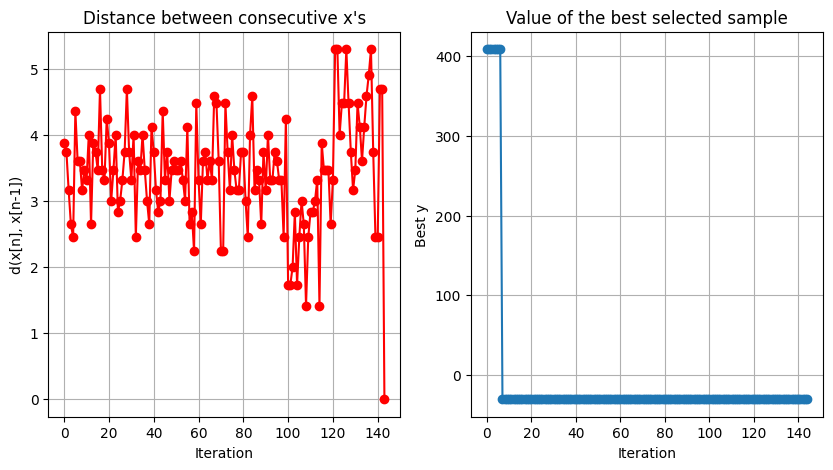

In [42]:
y=[0]+list(myBopt.x_opt)+[0]
print(y)
print(myBopt.x_opt) 
print(myBopt.fx_opt) 
myBopt.plot_convergence()

Best structure: [2, 2, 2, 1, 2, 2, 2, 1, 1] <br>
Maximum FOM: -37.55829028956106<br>
Time: 99002.15938186646